In [1]:
import gym
from gym import wrappers
from gym.spaces.utils import flatdim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import io
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

In [2]:
def play_video(ep_number: int):
    video = io.open(f"./gym-results/rl-video-episode-{ep_number}.mp4", 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

100%|██████████| 50000/50000 [00:06<00:00, 8261.96it/s]


Text(0.5, 1.0, 'Episode lengths over 100 episodes')

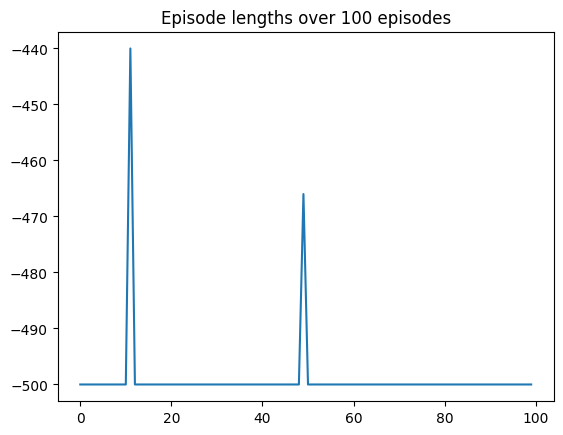

In [10]:
env = gym.make("Acrobot-v1")
# env = wrappers.RecordVideo(env, "./acrobot")
env.reset()

num_steps = 50000
random_rewards = []
n_eps = 0
ep_rs = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info = env.step(action)
   ep_rs += reward

   if done:
      observation = env.reset()

      random_rewards.append(ep_rs)

      ep_rs = 0
      n_eps += 1
   
env.close()

plt.plot(random_rewards)
plt.title(f"Episode lengths over {n_eps} episodes")

100%|██████████| 50000/50000 [00:11<00:00, 4421.66it/s]


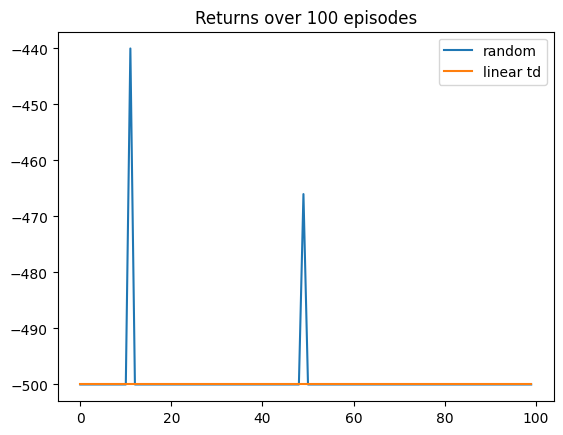

In [20]:
# Simple Linear Function grad-Q learning
env = gym.make("Acrobot-v1")
# env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
obs = env.reset()

num_steps = 50000
lr = 1e-4
epsilon = 0.01
gamma = 0.99
weights = np.zeros((flatdim(env.action_space), flatdim(env.observation_space)))

def policy(action_vals, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()    
    return np.random.choice(np.where(action_vals == action_vals.max())[0])


td_rewards = []
n_eps = 0
ep_rs = 0
for _ in trange(num_steps):
    action_vals = np.matmul(weights, obs)
    action = policy(action_vals, epsilon)
    next_obs, reward, done, info = env.step(action)

    ep_rs += reward

    # Compute targets
    q_next= np.max(np.matmul(weights, next_obs))
    q_target = reward + gamma*(1-done)*q_next

    # Predicted values
    q_pred = action_vals[action]

    bellman_error = q_target - q_pred
    grad = obs
    weights[action, :] += lr * bellman_error * grad

    if done:
        next_obs = env.reset()

        td_rewards.append(ep_rs)
        ep_rs = 0
        n_eps += 1


    obs = next_obs
env.close()

plt.plot(random_rewards, label='random')
plt.plot(td_rewards, label='linear td')
plt.title(f"Returns over {n_eps} episodes")
plt.legend()

100%|██████████| 50000/50000 [00:22<00:00, 2197.54it/s]


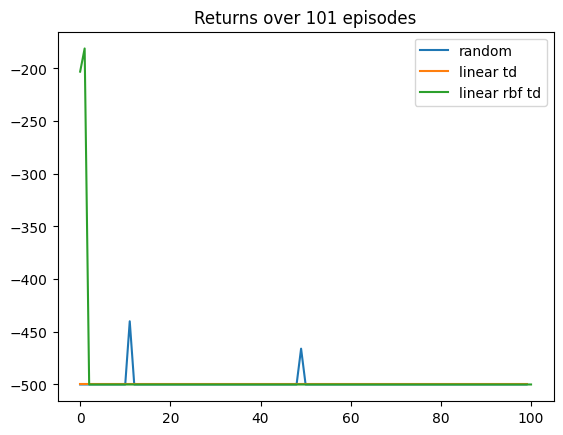

In [24]:
# Linear Q-learning with RBFs
env = gym.make("Acrobot-v1")
# env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
obs = env.reset()

nS = flatdim(env.observation_space)
nA = flatdim(env.action_space)

num_steps = 50000
lr = 1e-4
epsilon = 0.01
gamma = 0.99

n_samples = 10
shape_param = 2

weights = np.zeros((nA, n_samples))

def rbf(c, shape):
    """
    Creates a radial basis function with given shape and center params, also returns its gradient 
    """
    def rbf_dot(obs):
        return np.exp(-shape * np.dot(obs - c, obs - c))
    
    return rbf_dot

obs_max = env.observation_space.high
obs_min = env.observation_space.low

center_samples = np.random.uniform(low=obs_min, high=obs_max, size=(n_samples, nS))
rbfs = [rbf(center, shape_param) for center in center_samples]

def action_values(rbfs):
    def action_values_dot(obs, weights):
        rbf_list = np.array([rbf(obs) for rbf in rbfs])
        return np.matmul(weights, rbf_list)

    return action_values_dot

def grads(rbfs):
    def grad_dot(obs):
        return np.array([rbf(obs) for rbf in rbfs])

    return grad_dot

values = action_values(rbfs)
grad = grads(rbfs)

def policy(action_vals, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()    

    return np.random.choice(np.where(action_vals == action_vals.max())[0])


rb_td_rewards = []
n_eps = 0
ep_rs = 0
for _ in trange(num_steps):
    action_values = values(obs, weights)
    action = policy(action_values, epsilon)
    next_obs, reward, done, info = env.step(action)

    ep_rs += reward

    # Compute targets
    q_next= np.max(values(next_obs, weights))
    q_target = reward + gamma*(1-done)*q_next

    # Predicted values
    q_pred = action_values[action]

    bellman_error = q_target - q_pred
    weights[action, :] += lr * bellman_error * grad(obs)

    if done:
        next_obs = env.reset()

        rb_td_rewards.append(ep_rs)
        n_eps += 1
        ep_rs = 0

    obs = next_obs
env.close()

plt.plot(random_rewards, label='random')
plt.plot(td_rewards, label='linear td')
plt.plot(rb_td_rewards, label='linear rbf td')
plt.title(f"Returns over {n_eps} episodes")
plt.legend()